In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers ## used for the embedding layer
from tensorflow.keras.models import Model ## used for the model
from tensorflow.keras.optimizers import Adam ## adam is used for optimization
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten ## activation is used for the activation function, batch normalization is used for normalizing the data, input is used for the input layer, embedding is used for the embedding layer, dot is used for the dot product, dense is used for the dense layer, flatten is used for flattening the data
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping ## model checkpoint is used for saving the model, learning rate scheduler is used for scheduling the learning rate, tensorboard is used for visualizing the data, early stopping is used for stopping the training

from wordcloud import WordCloud
%matplotlib inline 
## it will compress your graph within your code 

In [213]:
pip install matplotlib wordcloud ## wordcloud is a library made for visualizing related to our text related data 


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### READING ANIMELIST.CSV

In [214]:
import os

In [215]:
INPUT_DIR = os.path.join("..","artifacts","raw") ##.. to go to the parent directory and then go to the artifacts and then raw

In [216]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [217]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [218]:
len(rating_df)

5000000

#### DATA PROCESSING

In [219]:
n_ratings = rating_df["user_id"].value_counts() ## it will count the number of ratings given by each user..for seprating the experienced users and the new users
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy() ## it will filter the users who have given more than 400 ratings and then copy the data to the rating_df

In [220]:
len(rating_df)

3246641

In [221]:
min_rating =min(rating_df["rating"])

In [222]:
max_rating =max(rating_df["rating"])

In [223]:
max_rating

10

In [224]:
avg_rating =np.mean(rating_df["rating"])

In [225]:
avg_rating

np.float64(4.122732695114736)

In [226]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64) ## it will normalize the rating between 0 and 1

In [227]:
rating_df.duplicated().sum()

np.int64(0)

In [228]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [229]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}## it will encode the user ids to the integer values
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)## it will map the user ids to the integer values in user column


In [230]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [231]:
n_users = len(user2user_encoded)

In [232]:
n_users

4203

In [233]:
## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

In [234]:
anime_ids = rating_df["anime_id"].unique().tolist() ## creating a list of unique anime ids
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [235]:
n_anime = len(anime2anime_encoded)

In [236]:
n_anime

17149

In [237]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)## create a randomness in our data for training and testing 

In [238]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [239]:
## changing the data into input and output formaat 
X = rating_df[["user","anime"]].values ## it will create a numpy array of user and anime columns
y = rating_df["rating"] ## it will create a numpy array of rating column

In [240]:
y

0          0.9
1          0.7
2          0.0
3          0.0
4          0.9
          ... 
3246636    1.0
3246637    0.0
3246638    0.8
3246639    0.7
3246640    1.0
Name: rating, Length: 3246641, dtype: float64

In [241]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size ## it will give the number of rows in the data - 1000 for training

In [242]:
X_train , X_test , y_train , y_test = ( ##This line of code is performing a manual train-test split using slicing, based on an index variable train_indices.
    X[:train_indices], ##Take the first 'train_indices' samples for training features
    X[train_indices :],##Take the rest for testing features
    y[:train_indices],##Take the first 'train_indices' samples for training labels
    y[train_indices:],##Take the rest for testing labels
)

In [243]:
len(X_train)

3245641

In [244]:
len(y_train)

3245641

In [245]:
len(X_test)

1000

In [246]:
len(y_test)

1000

In [247]:
type(X_train) ## check whether they are in numpy array format or not because model accept only numpy array format

numpy.ndarray

In [248]:
X_train_array = [X_train[: , 0] , X_train[: ,1]] ##	X_train_array is a list: [first_column, second_column] of X_train || 1st column is user and 2nd column is anime
X_test_array = [X_test[: , 0] , X_test[: ,1]] ##  X_test_array is a list: [first_column, second_column] of X_test

In [249]:
X_test_array

[array([ 266, 2572, 2555,  658,   88, 2775, 3050,  155,  248, 3457, 3595,
        2772, 3286, 3825, 3786, 1348, 1939,  254, 1370, 1116, 4021,  259,
         959, 1780, 1999, 4092, 2980, 3680, 3751, 1360, 4130, 3568,  181,
        3286,  583, 3594, 2622, 2819, 2412, 1562, 3423, 1134,   33, 3798,
        1830, 3716,  386,  788, 4159, 3397, 1705, 2035, 2077, 3685,  791,
        3419, 2324, 1376, 3405, 3410, 1922, 1662, 2582, 3467, 1242, 2860,
        1662, 4089,   97, 3439, 1683, 2050, 2798, 2995,  975, 2050, 2511,
         665, 1404, 1820, 4172, 3335,  400,  982, 1242, 2099,  352, 3741,
         438, 2767,  402, 3542, 2292, 2670, 3324, 3856, 4062, 3999,   99,
        1314, 1308,  715,   45, 3335,   81,  538,  195, 1986,  682, 1766,
         752, 1326, 3116,  133, 1841, 3713, 3886,  899, 4103, 3263, 1644,
        2216, 2481, 4131, 3069, 3403, 1457, 1209, 1166,  832, 1803, 3920,
        1317, 2582, 1906,  311, 4117, 2496, 3210, 1399, 2276, 1892, 1093,
        3270, 3568, 3825, 1659, 2813, 

In [250]:
type(X_test_array)

list

In [251]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

Embeddings are used in model architectures to transform high-dimensional categorical data (like user IDs, movie IDs, or words) into lower-dimensional, dense vectors that are learned during training. These vectors capture meaningful relationships and similarities between categories, allowing the model to generalize better, reduce computational cost, and improve performance—especially in tasks like recommendation systems and natural language processing.we don't use one hot encoding dipite of it we use embedding body


In [252]:
def RecommenderNet():
    embedding_size =128 ## embedding size is the number of values in dense vector representing each word 

    user = Input(name="user",shape=[1]) ## first input

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user) ## embedding layer for user 

    anime = Input(name="anime",shape=[1]) ## second input 

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime) ## embedding layer for anime

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding]) ## dot product of user and anime embedding it signifies the similarity between the user and anime || axis = 2means 2 input 

    x = Flatten()(x) ## it converts the high dimensional vector in single dimensional vector || 128->1 dimensional vector
## layers that are generally created in all deep learning project 
    x = Dense(1,kernel_initializer='he_normal')(x) 
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
## make a model 
    model = Model(inputs=[user,anime], outputs=x) ## input user and anime and outpur is x
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam') ## model.compile() configures the model for training by specifying the optimizer, loss function, and evaluation metrics.
    return model

In [253]:
model = RecommenderNet() ## create a model or call the function or initialize the model

In [254]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [255]:
start_lr = 0.00001 ##it is the starting learning rate for the model
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5 ## it is the number of epochs for the model to train || epoch is one full pass through the entire training dataset.
sustain_epochs = 0 ## it is the number of epochs to sustain the maximum learning rate
exp_decay = 0.8 ## it is the decay rate for the learning rate || it is used to reduce the learning rate over time to help the model converge better.

def lrfn(epoch): ##it is used to find best learning rate for the model
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [256]:
##EarlyStopping is a Keras callback that stops training when a monitored metric stops improving.It helps prevent overfitting by restoring the best model weights after early stop.
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5' ## it is the path where weight for the model will be stored

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True) ## if the model performance will not improve for 3 epochs then it will stop the training and restore the best weights

In [257]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [258]:
history = model.fit( ## model training
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test), ## on which the validation will be done
    callbacks=my_callbacks
)
## accuracy is low as we only used 5M rows not 70M rows

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.8049 - mae: 0.3829 - mse: 0.1987 - val_loss: 0.7774 - val_mae: 0.3772 - val_mse: 0.1898 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.8013 - mae: 0.3815 - mse: 0.1972 - val_loss: 0.8068 - val_mae: 0.3822 - val_mse: 0.1989 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.7958 - mae: 0.3794 - mse: 0.1950 - val_loss: 0.8058 - val_mae: 0.3821 - val_mse: 0.1985 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.7876 - mae: 0.3764 - mse: 0.1919 - val_loss: 0.8022 - val_mae: 0.3814 - val_mse: 0.1972 - learning_rate: 3.4000e-05


In [259]:
model.load_weights(checkpoint_filepath)

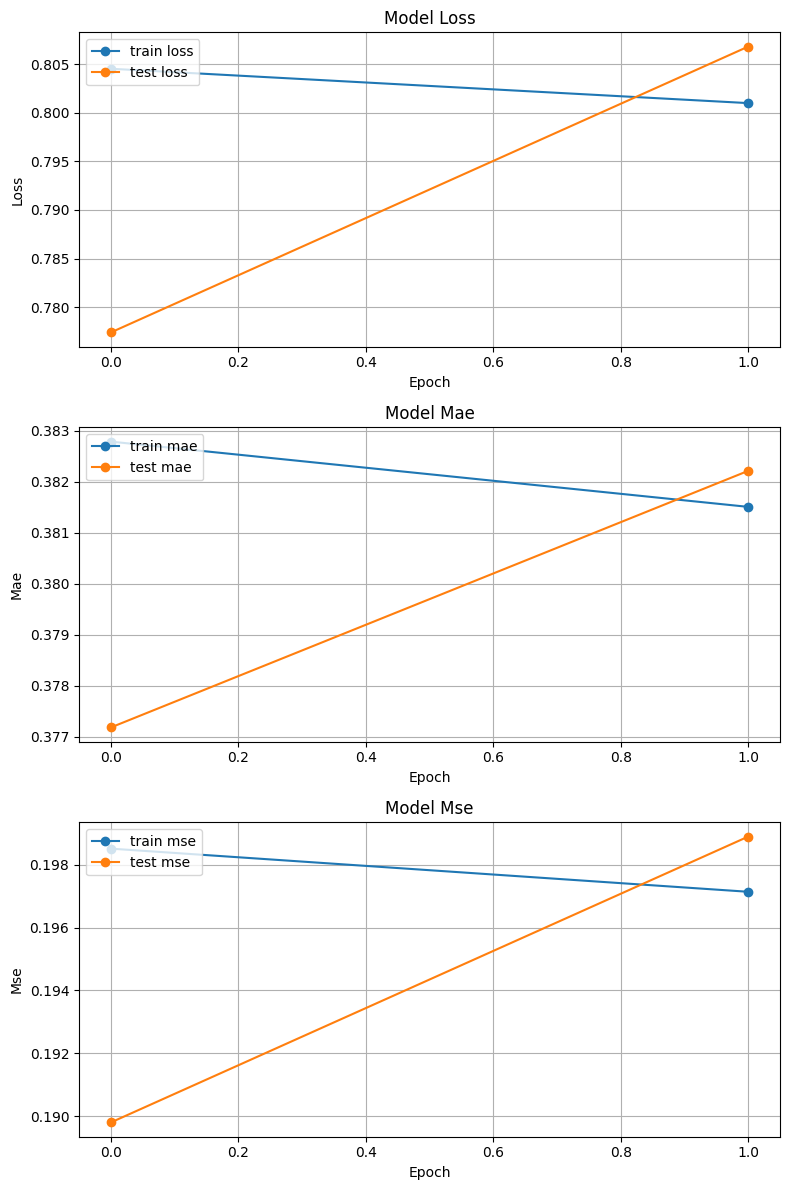

In [260]:
metrics = ["loss", "mae", "mse"] ## just copy from chat GPT

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()
## It will show the graph for loss, mae and mse for train and test data
## this graph is very irregular and not smooth because we have used only 5M rows not 70M rows

In [261]:
def extract_weights(name,model): ## enime weight is stored in anime_embedding and user weight is stored in user_embedding
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1)) ## it will normalize the weights and make the length of the vector 1
    return weights

In [262]:
anime_weights = extract_weights("anime_embedding",model)

In [263]:
user_weights = extract_weights("user_embedding",model)

#### READING ANIME.CSV

In [264]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [265]:
df = df.replace("Unknown",np.nan) ## replace unknown with nan

In [266]:
def getAnimeName(anime_id): ## it will return the name of the anime with the given anime id
    try: ## there is 2 name value one is name and other is eng name then if eng name is not available then it will take the name
        name = df[df.anime_id == anime_id].eng_version.values[0] ##  
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name
##We use [0] to extract the first (and usually only) matching value from the array returned by .values, giving us the actual English anime name instead of a one-element array.


In [267]:
df["anime_id"] = df["MAL_ID"] ## it will create a new column anime_id and copy the values from MAL_ID
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x)) ## it will apply the getAnimeName function to the anime_id column and create a new column eng_version

In [268]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [269]:
getAnimeName(6702)

'Fairy Tail'

In [270]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last") ## it will sort the data by score in descending order and put the nan values at the last  

In [271]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [272]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [273]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [274]:
def getAnimeFrame(anime,df): ## we can pass either the enime id or the name of the anime to get the data of the anime
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [275]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [276]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [277]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [278]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [279]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [280]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [281]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [282]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [283]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [284]:
pd.set_option("max_colwidth",None) ## it will set the max column width to none so that we can see the full synopsis of the anime initially only small part of the synopsis is shown 

In [285]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False): ## df is anime.csv || n is how many recommendation you want || return_dist is whether you want to return the distance or not || neg is whether you want to find the closest(if false) or farthest anime
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0] ## it will apply the getAnimeFrame function to the name and get the anime_id of the anime
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array || similarity btw the given weight that are anime weight(full vector ) and weight of the encoded index(one value from the vector) input name weight || compair weight of naruto with weight of all other anime
    sorted_dists = np.argsort(dists) ##it is short in ascending order least similar to most similar of input anime to other anime

    n = n + 1 ## it is used to get the n+1 values because the first value will be the same anime that we are passing and want 10 other that itself

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n] ## it will short the values in ascending order and get the first n values || it will give the farthest anime to the given anime || give the least similar anime
    else:
        closest = sorted_dists[-n:] ## it will short the values in descending order and get the last n values || it will give the closest anime to the given anime || give the most similar anime
  ##eg[54,588,24] closest 
    # Return distances and closest indices if requested
    if return_dist: ## if true then it will return the distance and closest anime
        return dists, closest ## but in our case it is false

    # Build the similarity array
    SimilarityArr = []
    for close in closest: ## uper diya ha || loop through the closest anime similar || get every details one by one of anime in the closest anime vector
        decoded_id = anime2anime_decoded.get(close) ## it will get the decoded_id for the close anime
        
        if decoded_id is None:  ## check if decoded_id is None
            continue  ## skip to the next iteration if None
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0] ## we only want eng_version genresvalue from the anime frame
        genre = anime_frame.Genres.values[0]
        similarity = dists[close] ## it will get the similarity score of the close anime(index 1) with the given anime 
   

        SimilarityArr.append({ ## similarityarr.append() is used to append the values to the list || append means to add the values to the list
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })## pd.DataFrame(SimilarityArr) this will give a table in column with the anime id, name, similarity and genre of the anime
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False) ## this will sort the DataFrame by similarity in descending order
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1) ## if the anime id is not equal to the index then drop the anime id column and return the frame
# Filter out the row where anime_id is equal to the given index,using this->Frame.anime_id != index
# because we don't want to include the input anime itself (e.g., in recommendations).
# Then drop the 'anime_id' column from the resulting DataFrame since it's no longer needed.

In [286]:
find_similar_animes( ## demo testing
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
) ## greater similarity sorce greater similarity low similariy because 5m problem

,name,similarity,genre
9,Jue Shi Wu Hun,0.326630,"Action, Fantasy, Martial Arts"
8,Roba Chotto Suneta,0.314729,"Kids, Music"
7,Yao Shen Ji Zhi Ying Yao Pian,0.311620,"Action, Adventure, Demons, Romance, Martial Arts, Fantasy"
6,Macross XX,0.311570,"Action, Mecha"
5,Mahou no Yousei Persia: Kaiten Mokuba,0.311051,"Comedy, Magic"
4,Who's Left Behind?,0.308773,"Historical, Drama"
3,Kanon Kazahana,0.300982,"Drama, Romance, Slice of Life, Supernatural"
2,Momotarou Densetsu,0.300172,"Adventure, Comedy"
1,Z.O.E. 2167 Idolo,0.299101,"Action, Space, Mecha, Romance, Military, Drama, Sci-Fi"
0,Blue Submarine No. 6,0.298668,"Action, Adventure, Mecha, Military, Sci-Fi"


### USER BASED RECOMMENDATION

In [287]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity ## similarity score of the close user(index 1) with the given user
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input] ## 1st similar user is data frame and second is the coumn
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [288]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded) ## make sure to pass the user id in int format

,similar_users,similarity
9,13176,0.375705
8,14135,0.301514
7,994,0.300231
6,16233,0.280106
5,1631,0.277957
4,2731,0.275288
3,13495,0.273527
2,15172,0.271490
1,7150,0.254468
0,2523,0.250451


In [289]:
## visualization of the data
def showWordCloud(all_genres): ##  make a word cloud of the given input || when user specift the plot is true then we use this function
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [290]:
from collections import defaultdict

In [291]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [292]:
def getFavGenre(frame , plot=False):## it will get the favorite genre() of the user and plot the graph if plot is true and if plot is false then it will not plot the graph || genre is the column name in the anime.csv file
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [293]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [294]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id] ## retrive all the anime that user has rated

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75) ## it will calculate the 75th percentile of the rating given by the user || it will give the value of rating that is greater than 75% of the ratings given by the user

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile] ## it will filter the anime that are rated greater than the 75th percentile of the rating given by the user

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values ## short the anime by rating in descending order and get the anime id of the top rated animes
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)] ## filter the anime that are rated greater than the 75th percentile of the rating given by the user in the df (anime.csv) file
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




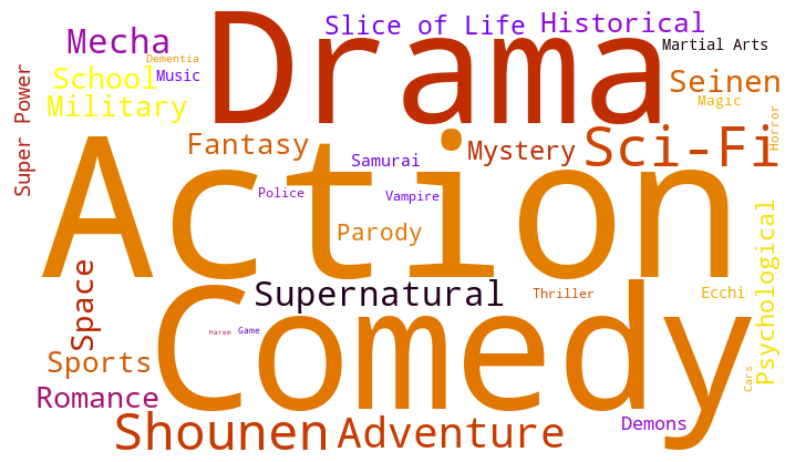

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [295]:
get_user_preferences(11880 , rating_df, df , plot=True) ## it shows wich anime the user has watched and which genre he likes the most bigger the word bigger the genre

In [296]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded) ## make sure to pass the user id in int format

,similar_users,similarity
9,13176,0.375705
8,14135,0.301514
7,994,0.300231
6,16233,0.280106
5,1631,0.277957
4,2731,0.275288
3,13495,0.273527
2,15172,0.271490
1,7150,0.254468
0,2523,0.250451


In [ ]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values: ## loop through the similar users
        pref_list = get_user_preferences(int(user_id) , rating_df, df) ## user preference of each user

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)] ## || user_pref is the anime that user has watched  and rated and pref_list is the anime that are watched and rated  by the similar users so we have to match from eng_version column of both the dataframes and filter the anime that are already watched by the user

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values) ## add the anime that are not watched by the user to the anime_list

    if anime_list: ## if anime list have values then we will proceed
            anime_list = pd.DataFrame(anime_list) ## converted into data frame

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n) ## shorting and flatten (ravel) (1d) anime_list || we get top n anime that are not watched by the user and then we get the count of the anime that are not watched by the user || short in descending order

            for i,anime_name in enumerate(sorted_list.index): ## loop through the anime name in the sorted list
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0] ##Find the value in sorted_list where the index matches anime_name, and assign that value to n_user_pref || return the count  how many people like this anime by comparing the anime name with the sorted list index

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [299]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [300]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [301]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Spirited Away,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."


### HYBRID RECOMMENDER SYSTEM

In [ ]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5): ## this parameter will define how much hybrid your recommendation system is if 0.5 then it will be 50% user based and 50% content based if 0.7 then it will be 70% user based and 30% content based

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist() ## it will get the anime name from the user recommended animes and convert it into list
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list: ## loop through the user recommended anime list
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df) ## find similar animes of each anime in the user recommendation list 

        if similar_animes is not None and not similar_animes.empty: ## checking that we are not getting empty or null values
            content_recommended_animes.extend(similar_animes["name"].tolist()) ## it will get the anime name from the similar animes and convert it into list and add to the content recommended anime list
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {} 

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight ## it will return the anime name and the score of the anime in the user recommended anime list || score is the number of times the anime is recommended by the similar users initially 1 then it will be increased by the user weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight ## it will return the anime name and the score of the anime in the content recommended anime list || score is the number of times the anime is recommended based on content similarity

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True) ## it will sort the anime based on the score in descending order || x[1] is the score of the anime and x[0] is the anime name

    return [anime for anime , score in sorted_animes[:10]]  ## it will return the top 10 anime based on the score || anime is the anime name and score is the score of the anime



In [303]:
hybrid_recommendation(11880)

['Spirited Away', 'Angel Beats!', 'Toradora!', 'Nisekoi:False Love', 'My Teen Romantic Comedy SNAFU', 'The Future Diary', 'Attack on Titan', 'A Certain Magical Index', 'Soul Eater', 'Clannad ~After Story~']


['Spirited Away',
 'Angel Beats!',
 'Toradora!',
 'Nisekoi:False Love',
 'My Teen Romantic Comedy SNAFU',
 'The Future Diary',
 'Attack on Titan',
 'A Certain Magical Index',
 'Soul Eater',
 'Clannad ~After Story~']